<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE5237-Decision-Theory/blob/main/Project%202/Counterfeiting_of_banknotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**

#**Project 2: Counterfeiting of banknotes**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Load data and apply Z-Score Normalization on features**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from csv
file_path = '/content/drive/MyDrive/data.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target variable (y)
X = data.drop(columns=['class']) # Drop only column 'class' to keep the features
y = data['class'] # Keep only column 'class' which is the target

# Show the initial amount of sample points for each class before splitting
initial_class_counts = y.value_counts()
print("Sample points for each class before splitting:")
print(f"Class 0: {initial_class_counts[0]} samples")
print(f"Class 1: {initial_class_counts[1]} samples")

# Apply Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # Convert the scaled data into a DataFrame

Sample points for each class before splitting:
Class 0: 762 samples
Class 1: 610 samples


##**Question 1**

###**PCA and Splitting into Training, Validation and Test Set**


Principal Components:
     variance  skewness  curtosis   entropy
PC1  0.248772  0.639323 -0.612707 -0.392389
PC2  0.754591 -0.050340 -0.153459  0.636010


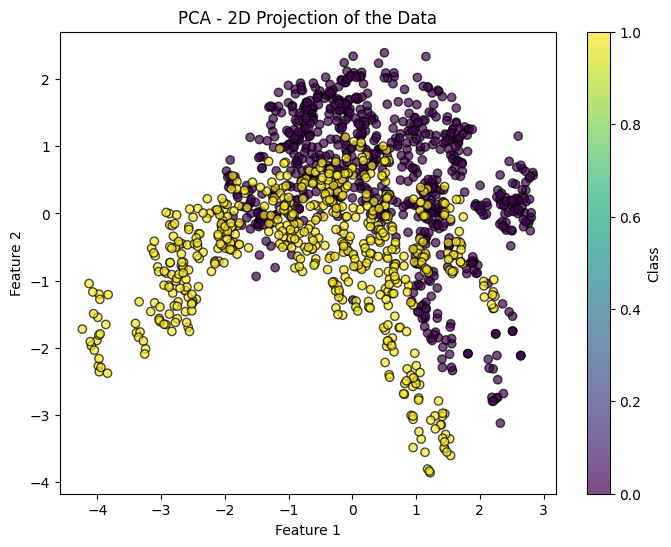

Sample points for each class after splitting:

Training Set:
Class 0: 457 samples (59.97% of class 0)
Class 1: 366 samples (60.00% of class 1)

Validation Set:
Class 0: 152 samples (19.95% of class 0)
Class 1: 122 samples (20.00% of class 1)

Test Set:
Class 0: 153 samples (20.08% of class 0)
Class 1: 122 samples (20.00% of class 1)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the number of features to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

# Convert the PCA result into a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Function to calculate and display counts and percentages relative to each class
def display_counts_and_percentages(label, y_subset):
    counts = y_subset.value_counts()
    print(f"\n{label} Set:")
    for cls in counts.index:
        print(f"Class {cls}: {counts[cls]} samples ({counts[cls] / y.value_counts()[cls] * 100:.2f}% of class {cls})")

# Display the contribution of each feature to each principal component
print("\nPrincipal Components:")
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
print(components_df)

# Plot the PCA features
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA - 2D Projection of the Data')
plt.show()

# Display the counts and percentages for training, validation, and test sets
print("Sample points for each class after splitting:")
display_counts_and_percentages("Training", y_train)
display_counts_and_percentages("Validation", y_val)
display_counts_and_percentages("Test", y_test)

##**Parzen Windows**

**STEP 1: Train and evaluate the different Parzen Windows and plot their PDFs with the decision boundaries**

Bandwidth: 0.1, Training Accuracy: 0.9247, Validation Accuracy: 0.8613
Bandwidth: 0.5, Training Accuracy: 0.8165, Validation Accuracy: 0.8102
Bandwidth: 1.0, Training Accuracy: 0.7922, Validation Accuracy: 0.7883
Bandwidth: 2.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774
Bandwidth: 5.0, Training Accuracy: 0.7618, Validation Accuracy: 0.7774


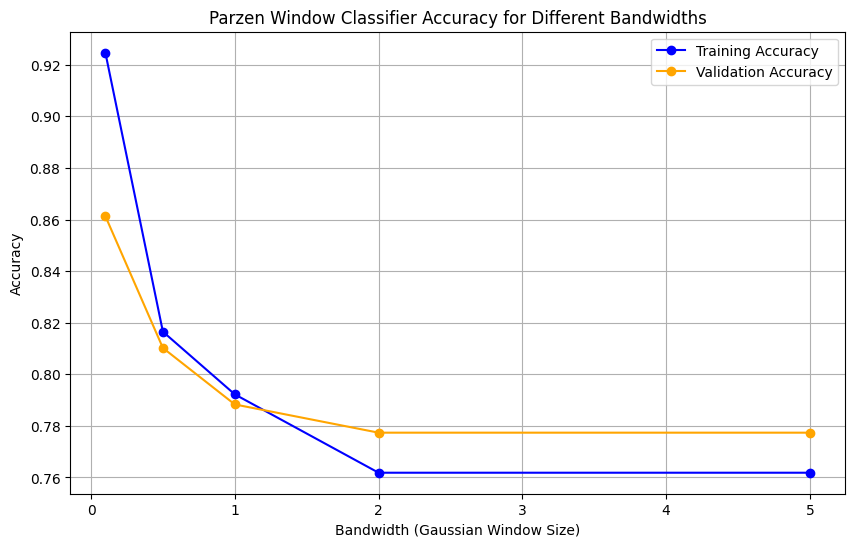

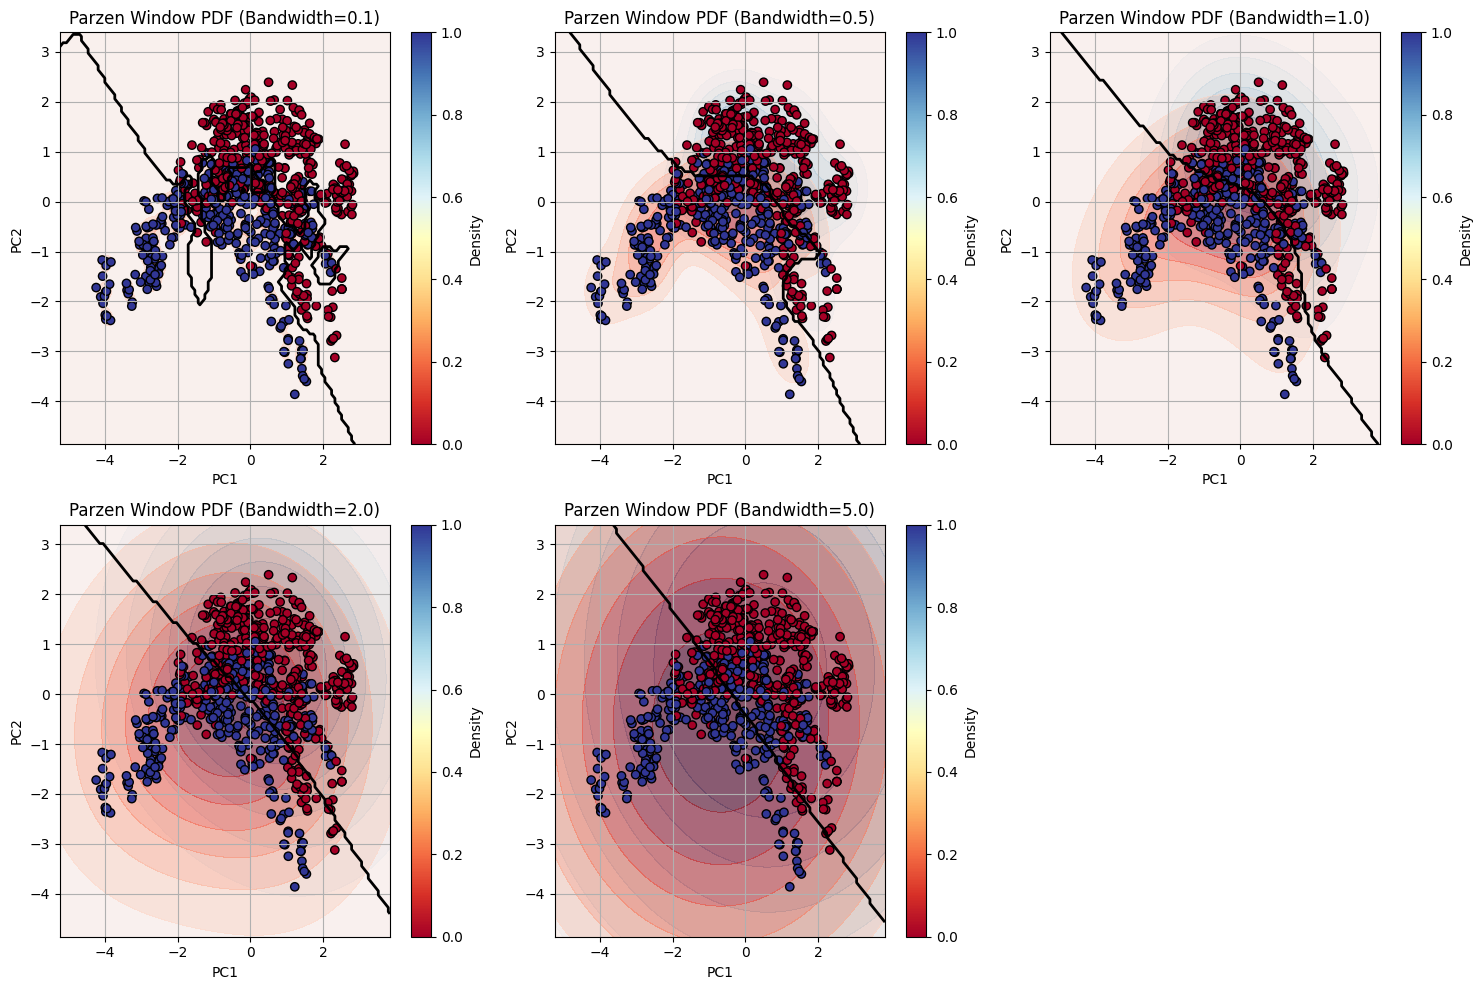

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parzen Window with Gaussian Kernel
def parzen_window(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    predictions = [] # List to store probabilty densities for the classes
    pdfs = {c: [] for c in classes}  # Dictionary to store PDFs for each class

    for x_test in X_test.values:
        class_probabilities = []

        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            class_probabilities.append(density)
            pdfs[c].append(density)

        # Classify based on the highest density estimate
        predicted_class = classes[np.argmax(class_probabilities)]
        predictions.append(predicted_class)

    return np.array(predictions), pdfs

# Parzen Window with Gaussian Kernel for PDF estimation
def parzen_window_pdf(X_train, y_train, X_test, bandwidth):
    classes = np.unique(y_train)
    pdfs = {c: [] for c in classes}  # Dictionary to store PDFs for each class

    # For each test point, compute the density estimate for each class
    for x_test in X_test.values:
        for c in classes:
            # Get the training data for the current class
            X_class = X_train[y_train == c]

            # Compute the Parzen window density estimate for the current class
            density = 0
            for x_train in X_class.values:
                # Gaussian kernel
                density += np.exp(-np.linalg.norm(x_test - x_train) ** 2 / (2 * bandwidth ** 2))

            # Normalize the density
            density /= len(X_class)
            pdfs[c].append(density)

    return pdfs

# Generate a grid of points for plotting
x_min, x_max = X_train['PC1'].min() - 1, X_train['PC1'].max() + 1
y_min, y_max = X_train['PC2'].min() - 1, X_train['PC2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Bandwidths to evaluate
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

# Store accuracies for training and validation sets
train_accuracies = []
val_accuracies = []

for bandwidth in bandwidths:
    # Predict on training set
    y_train_pred = parzen_window(X_train, y_train, X_train, bandwidth)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Predict on validation set
    y_val_pred = parzen_window(X_train, y_train, X_val, bandwidth)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    print(f"Bandwidth: {bandwidth}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(bandwidths, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(bandwidths, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='orange')
plt.xlabel('Bandwidth (Gaussian Window Size)')
plt.ylabel('Accuracy')
plt.title('Parzen Window Classifier Accuracy for Different Bandwidths')
plt.legend()
plt.grid(True)
plt.show()

# Plot PDFs for each bandwidth on a grid
plt.figure(figsize=(15, 10))
for bandwidth in bandwidths:
    pdfs = parzen_window_pdf(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    Z_class_0 = np.array(pdfs[0]).reshape(xx.shape)
    Z_class_1 = np.array(pdfs[1]).reshape(xx.shape)

    plt.subplot(2, 3, bandwidths.index(bandwidth) + 1)
    plt.contourf(xx, yy, Z_class_0, alpha=0.5, cmap='Blues')
    plt.contourf(xx, yy, Z_class_1, alpha=0.5, cmap='Reds')

    # Plot decision boundaries
    decision_boundaries = parzen_window(X_train, y_train, pd.DataFrame(grid_points, columns=['PC1', 'PC2']), bandwidth)
    decision_boundaries = decision_boundaries.reshape(xx.shape)
    plt.contour(xx, yy, decision_boundaries, levels=[0.5], linewidths=2, colors='black')

    # Plot training data points
    plt.scatter(X_train['PC1'], X_train['PC2'], c=y_train, cmap=plt.cm.RdYlBu, edgecolors='k', marker='o')

    plt.title(f'Parzen Window PDF (Bandwidth={bandwidth})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Density')
    plt.grid(True)

plt.tight_layout()
plt.show()

**STEP 2: Apply Parzen Window on testing data, calculate F1-Score and graph Learning Curves and ROC (w/AUC)**

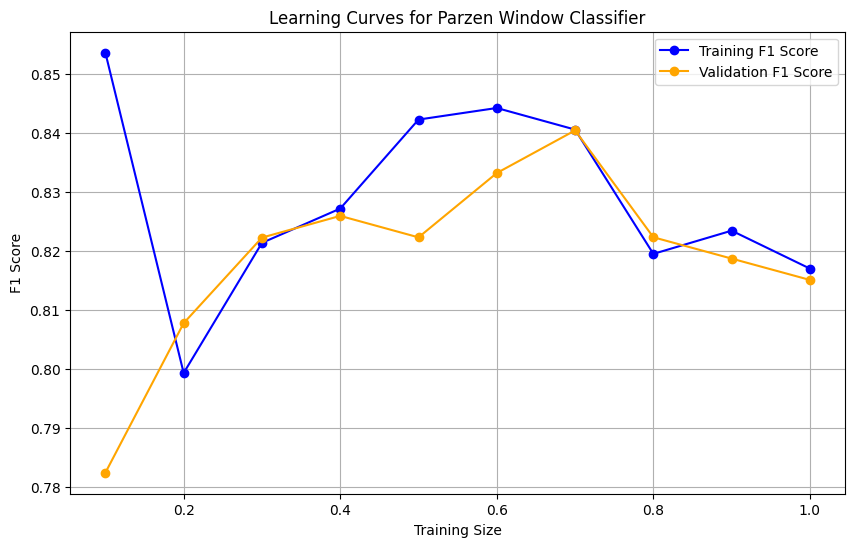

F1 Score for Parzen Window: 0.8151


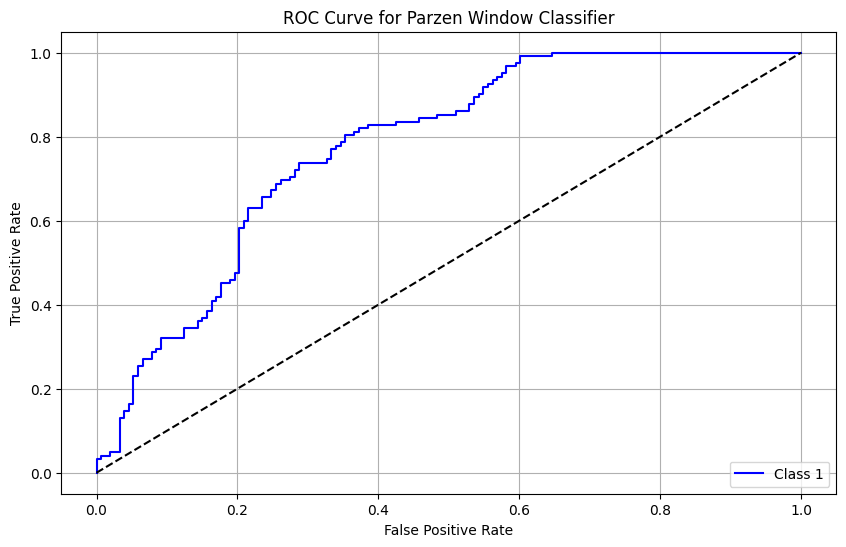

Average AUC Parzen Window: 0.7746


In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Function to generate learning curve data for Parzen Window classifier
def generate_learning_curve(X_train, y_train, X_test, y_test, bandwidth, step=0.1):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the Parzen window classifier on the current subset of training data
        y_train_pred = parzen_window(X_train_subset, y_train_subset, X_train_subset, bandwidth)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Validate on the full test set
        y_val_pred = parzen_window(X_train_subset, y_train_subset, X_test, bandwidth)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Set the optimal bandwidth (h=0.5)
bandwidth = 0.5

# Generate learning curves
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve(X_train, y_train, X_test, y_test, bandwidth)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for Parzen Window Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Use the Parzen window classifier with the optimal bandwidth h=1.0 to make the prediction
y_pred = parzen_window(X_train, y_train, X_test, bandwidth)

# Calculate the F1 score for the test set
f1_parzen = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score for Parzen Window: {f1_parzen:.4f}")

# ROC and AUC calculations
pdfs = parzen_window_pdf(X_train, y_train, X_test, bandwidth)
y_prob= np.array(pdfs[1])  # Probabilities for class 1

# Prepare true binary labels for class 1
y_true= (y_test == 1).astype(int)  # Binary labels for class 1 (1 if class 1, 0 otherwise)

# Compute ROC curve and AUC for class 1
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Class 1', color='blue')

# Plot the chance level (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Parzen Window Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the AUC score
print(f"Average AUC Parzen Window: {roc_auc:.4f}")

An **AUC of 0.83 is a strong result**, meaning that **the Parzen Window Classifier can distinguish Class 0 from Class 1 most of the time**. The steep rise at the start of the ROC curve indicates that the classifier achieves a high True Positive Rate (TPR) for Class 0 at a low False Positive Rate (FPR). This shows good discrimination of the 2 classes in general. However, the middle part of the curve might show some overlap between the classes, where the classifier struggles to distinguish between Class 0 and Class 1 for certain instances.

##**Question 2**

##**k-NN**

**STEP 1: Train and evaluate the kNN Model for different k values**

k: 1, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
k: 3, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 5, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 7, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 9, Training Accuracy: 0.9976, Validation Accuracy: 1.0000
k: 11, Training Accuracy: 0.9927, Validation Accuracy: 1.0000
k: 15, Training Accuracy: 0.9915, Validation Accuracy: 0.9891
k: 20, Training Accuracy: 0.9915, Validation Accuracy: 0.9891
k: 25, Training Accuracy: 0.9891, Validation Accuracy: 0.9891
k: 28, Training Accuracy: 0.9891, Validation Accuracy: 0.9891
k: 30, Training Accuracy: 0.9891, Validation Accuracy: 0.9891


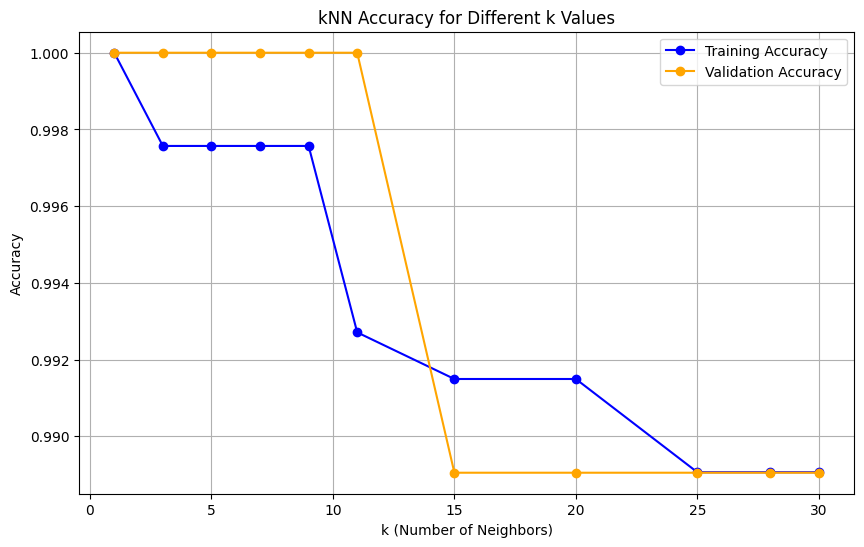

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Split initial data without PCA into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Test kNN for different values of k
k_values = [1, 3, 5, 7, 9, 11, 15, 20, 25, 28, 30]
training_accuracies = []
validation_accuracies = []

for k in k_values:
    # Create and train the kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on training and validation sets
    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)

    # Calculate accuracy for training and validation sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Store the accuracies
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)

    # Print accuracy for this k
    print(f"k: {k}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(k_values, training_accuracies, label='Training Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(k_values, validation_accuracies, label='Validation Accuracy', marker='o', linestyle='-', color='orange')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('kNN Accuracy for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

**STEP 2: Apply kNN Classifier on testing data, calculate F1-Score and graph Learning Curves and ROC (w/AUC)**

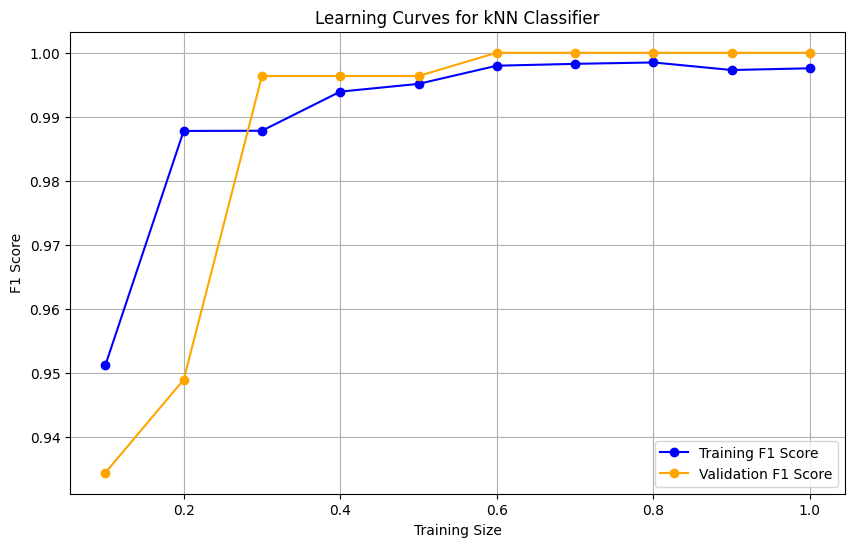

F1 Score for k-NN: 1.0000


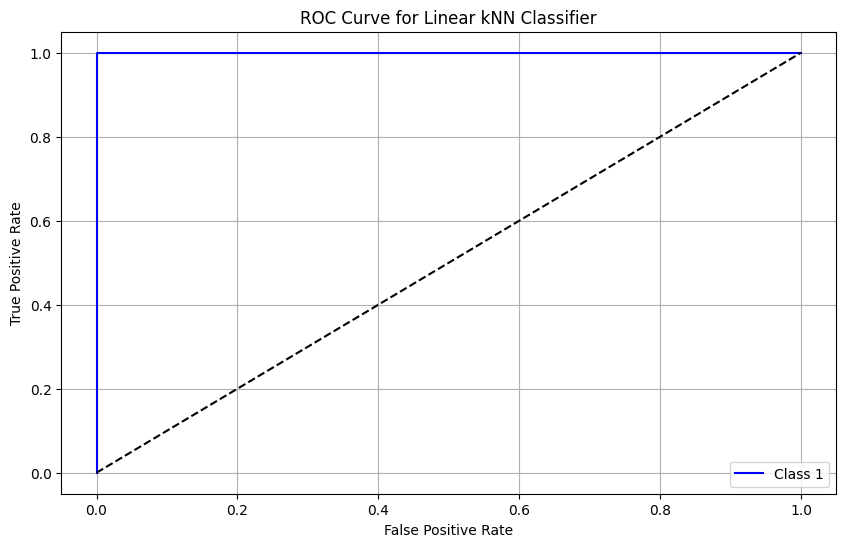

Average AUC for kNN: 1.0000


In [ ]:
# Function to generate learning curve data for kNN classifier
def generate_learning_curve_knn(X_train, y_train, X_test, y_test, k, step=0.1):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the kNN classifier on the current subset of training data
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_subset, y_train_subset)

        # Predict on the training set
        y_train_pred = knn.predict(X_train_subset)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Predict on the test set
        y_val_pred = knn.predict(X_test)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Initialize the kNN classifier
k = 5 # Choose the optimal value of k=5
knn = KNeighborsClassifier(n_neighbors=k)

# Generate learning curves
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve_knn(X_train, y_train, X_test, y_test, k)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for kNN Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Fit the kNN classifier on the data
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Calculate the F1 score for the testing set
f1_kNN = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance

# Output the F1 score for the testing set
print(f"F1 Score for k-NN: {f1_kNN:.4f}")

# ROC and AUC calculations
y_prob = knn.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the binary classification
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Class 1',  color='blue')

# Plotting the chance level (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear kNN Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the AUC score
print(f"Average AUC for kNN: {roc_auc:.4f}")

**STEP 3: Display on the 2d-plane the decision boundaries**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


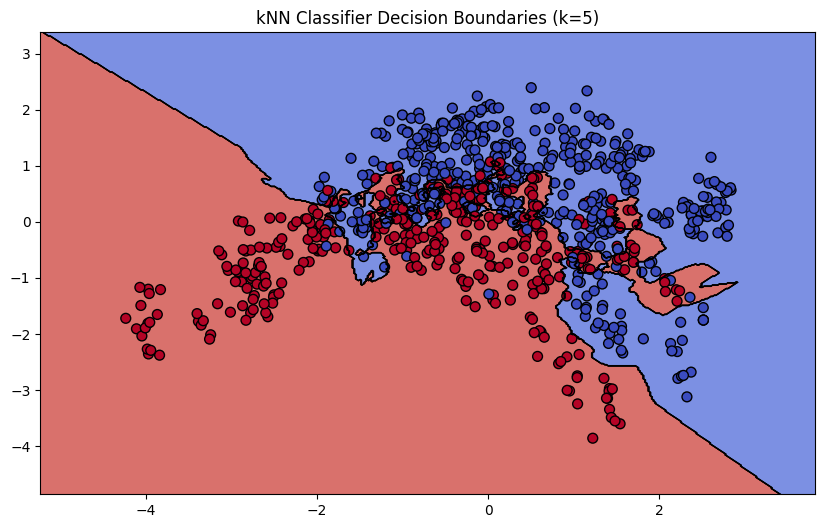

In [ ]:
# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Function to plot kNN decision boundaries with
def plot_knn_decision_boundaries(X, y, knn_model, title="kNN Decision Boundaries with Neighbors"):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the mesh
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary with filled regions
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)

    # Add contour lines for decision boundaries
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5)

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)

    plt.title(title)
    plt.show()

# Fit the kNN model on the PCA-transformed training data
k = 5  # Optimal k value
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Visualize the decision boundaries and neighbors on the PCA-transformed data
plot_knn_decision_boundaries(X_train.to_numpy(), y_train, knn, title=f"kNN Classifier Decision Boundaries (k={k})")

##**SVM**

**STEP 1: Train and evaluate the Linear and Non-Linear Models**

Best Linear SVM Parameters: {'C': 10}


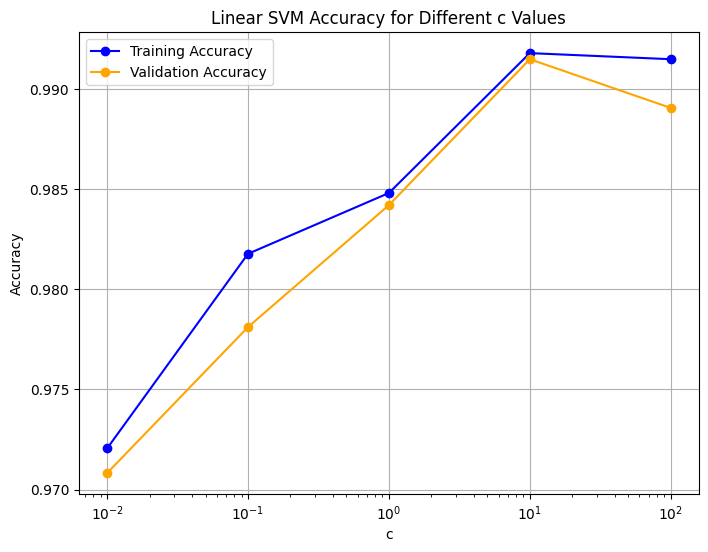

Best Non-Linear SVM Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


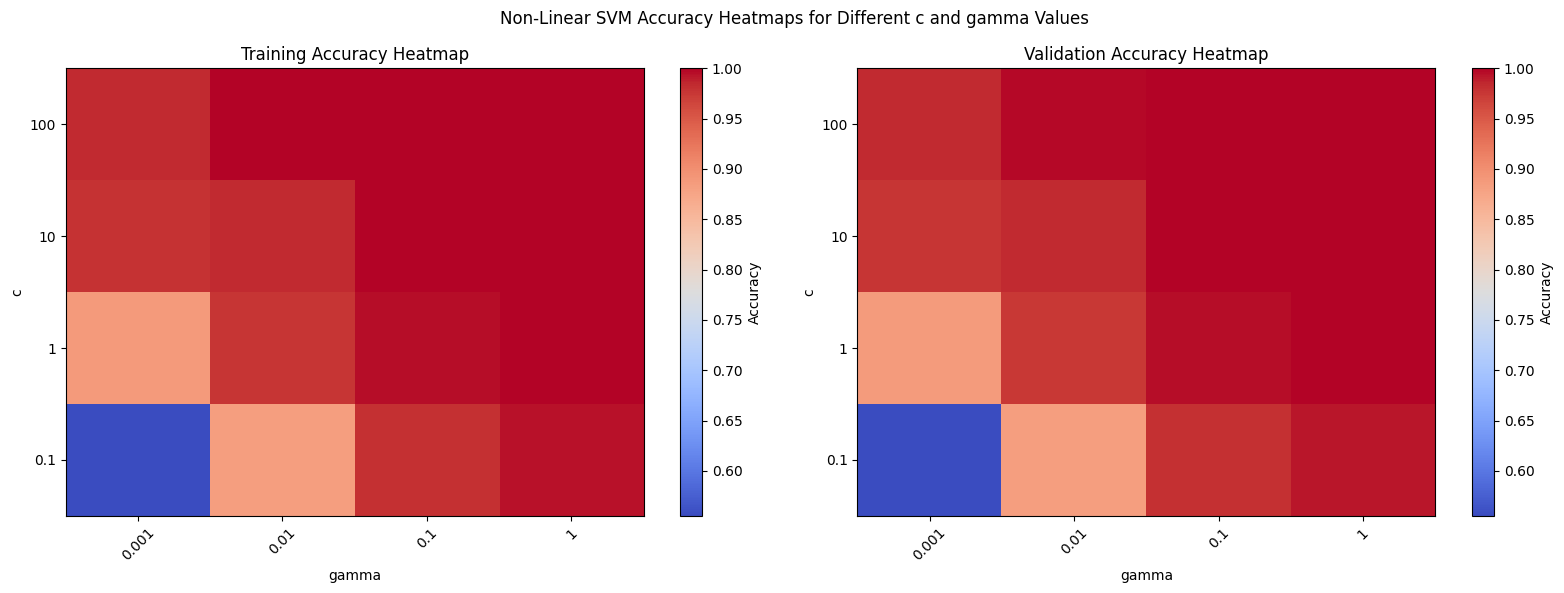

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Split initial data without PCA into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Linear SVM
def linear_svm(X_train, y_train, X_val, y_val):
    # Grid search for the best value of hyperparameter c using Cross Validation
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Find best model hyperparameter
    best_model = grid_search.best_estimator_
    print("Best Linear SVM Parameters:", grid_search.best_params_)

    # Extract training and validation accuracy from CV for plotting
    results = grid_search.cv_results_
    C_values = param_grid['C']
    mean_train_acc = results['mean_train_score']
    mean_val_acc = results['mean_test_score']

    # Plot accuracy vs. c
    plt.figure(figsize=(8, 6))
    plt.plot(C_values, mean_train_acc, marker='o', label='Training Accuracy', color='blue')
    plt.plot(C_values, mean_val_acc, marker='o', label='Validation Accuracy', color='orange')
    plt.xscale('log')
    plt.xlabel('c')
    plt.ylabel('Accuracy')
    plt.title('Linear SVM Accuracy for Different c Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Non-Linear SVM
def nonlinear_svm(X_train, y_train, X_val, y_val):
    # Grid search for the best values of hperparameters c and gamma using Cross Validation and rbf kernel
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Find best model hyperparameters
    best_model = grid_search.best_estimator_
    print("Best Non-Linear SVM Parameters:", grid_search.best_params_)

    # Extract trainig and validation accuracy results for the heatmap
    results = grid_search.cv_results_
    c_values = param_grid['C']
    gamma_values = param_grid['gamma']
    train_scores_matrix = np.array(results['mean_train_score']).reshape(len(c_values), len(gamma_values))
    val_scores_matrix = np.array(results['mean_test_score']).reshape(len(c_values), len(gamma_values))

    # Plot the 2 heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Training accuracy heatmap
    im1 = axes[0].imshow(train_scores_matrix, interpolation='nearest', cmap='coolwarm', aspect='auto', origin='lower')
    axes[0].set_title('Training Accuracy Heatmap')
    axes[0].set_xlabel('gamma')
    axes[0].set_ylabel('c')
    axes[0].set_xticks(range(len(gamma_values)))
    axes[0].set_xticklabels(gamma_values, rotation=45)
    axes[0].set_yticks(range(len(c_values)))
    axes[0].set_yticklabels(c_values)
    fig.colorbar(im1, ax=axes[0], label='Accuracy')

    # Validation accuracy heatmap
    im2 = axes[1].imshow(val_scores_matrix, interpolation='nearest', cmap='coolwarm', aspect='auto', origin='lower')
    axes[1].set_title('Validation Accuracy Heatmap')
    axes[1].set_xlabel('gamma')
    axes[1].set_ylabel('c')
    axes[1].set_xticks(range(len(gamma_values)))
    axes[1].set_xticklabels(gamma_values, rotation=45)
    axes[1].set_yticks(range(len(c_values)))
    axes[1].set_yticklabels(c_values)
    fig.colorbar(im2, ax=axes[1], label='Accuracy')

    plt.suptitle('Non-Linear SVM Accuracy Heatmaps for Different c and gamma Values')
    plt.tight_layout()
    plt.show()

# Train and evaluate models
linear_svm(X_train, y_train, X_val, y_val)
nonlinear_svm(X_train, y_train, X_val, y_val)

**STEP 2: Apply Linear SVM on testing data, calculate F1-Score and graph Learning Curves and ROC (w/AUC)**

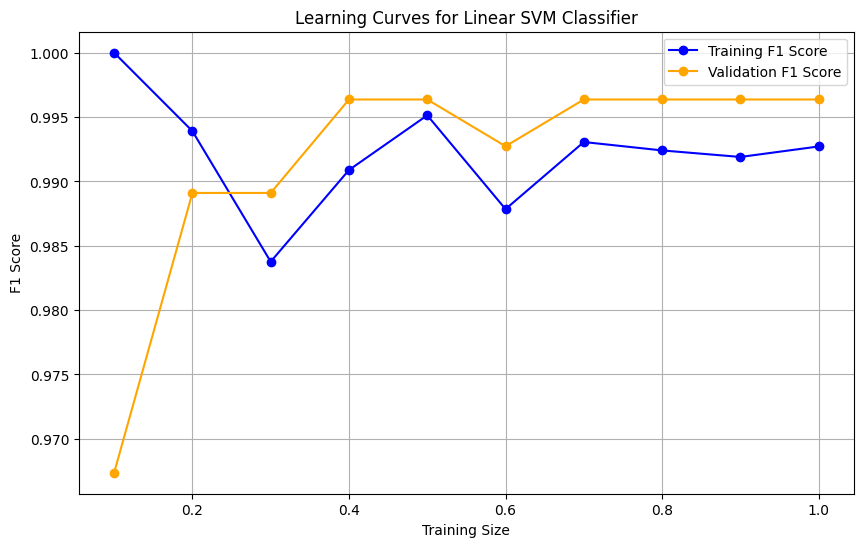

F1 Score for Linear SVM: 0.9964


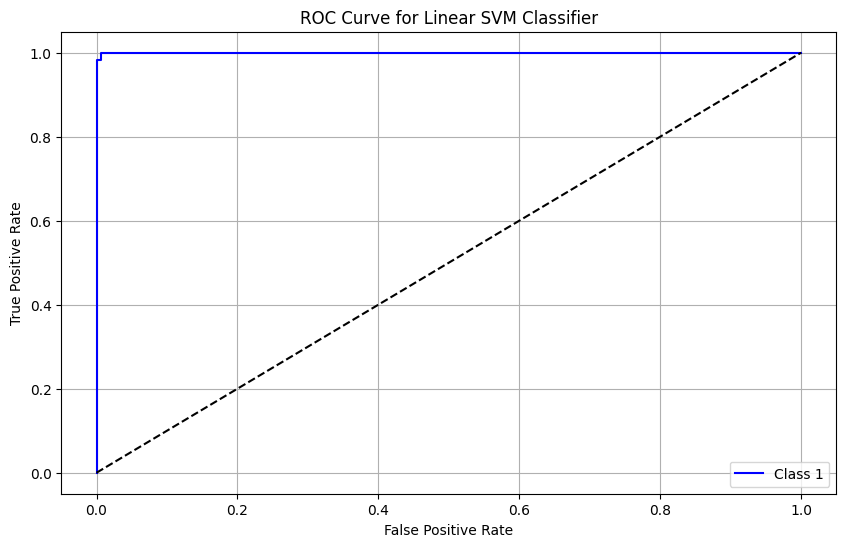

Average AUC for Linear SVM: 0.9999


In [ ]:
# Function to generate learning curve data for Linear SVM
def generate_learning_curve_svm(X_train, y_train, X_test, y_test, C=10):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the Linear SVM on the current subset of training data
        svm = SVC(C=C, kernel='linear', probability=True)
        svm.fit(X_train_subset, y_train_subset)

        # Predict on the training set
        y_train_pred = svm.predict(X_train_subset)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Predict on the test set
        y_val_pred = svm.predict(X_test)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Initialize the Linear SVM classifier with the optimal value c=10
optimal_c = 10
svm = SVC(C=optimal_c, kernel='linear', probability=True)

# Generate learning curves
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve_svm(X_train, y_train, X_test, y_test, C=optimal_c)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for Linear SVM Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Fit the Linear SVM classifier on the full training data
svm.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm.predict(X_test)

# Calculate the F1 score for the testing set
f1_svm = f1_score(y_test, y_pred, average='weighted')

# Output the F1 score for the testing set
print(f"F1 Score for Linear SVM: {f1_svm:.4f}")

# ROC and AUC calculations for Linear SVM
y_prob = svm.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the binary classification
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Class 1',  color='blue')

# Plotting the chance level (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear SVM Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the AUC score
print(f"Average AUC for Linear SVM: {roc_auc:.4f}")

**STEP 3: Display the support vectors of the Linear SVM on the 2d-plane**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


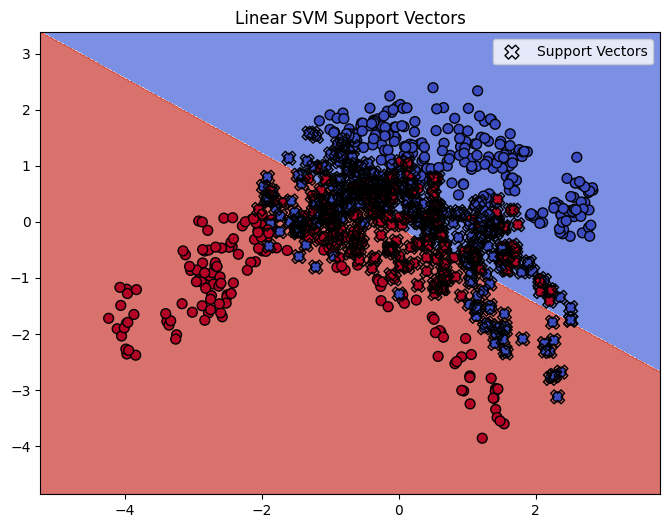

In [ ]:
# Split the data into 60% training, 20% validation, and 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Function to plot support vectors
def plot_support_vectors(X_train, y_train, svm, title='Linear SVM Support Vectors'):
    plt.figure(figsize=(8, 6))

    # Plot the decision boundary
    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)

    # Plot the training points and support vectors
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='black', s=100, label='Support Vectors', marker='X')

    plt.title(title)
    plt.legend()
    plt.show()

# Initialize the Linear SVM classifier with the optimal value c=10
optimal_c = 10
svm = SVC(C=optimal_c, kernel='linear', probability=True)

# Fit the Linear SVM classifier on the full training data
svm.fit(X_train, y_train)

# Plot support vectors after training the model (use PCA-reduced data for visualization)
plot_support_vectors(X_train.values, y_train, svm)

**STEP 4: Apply Non-Linear SVM on testing data, calculate F1-Score and graph Learning Curves and ROC (w/AUC)**

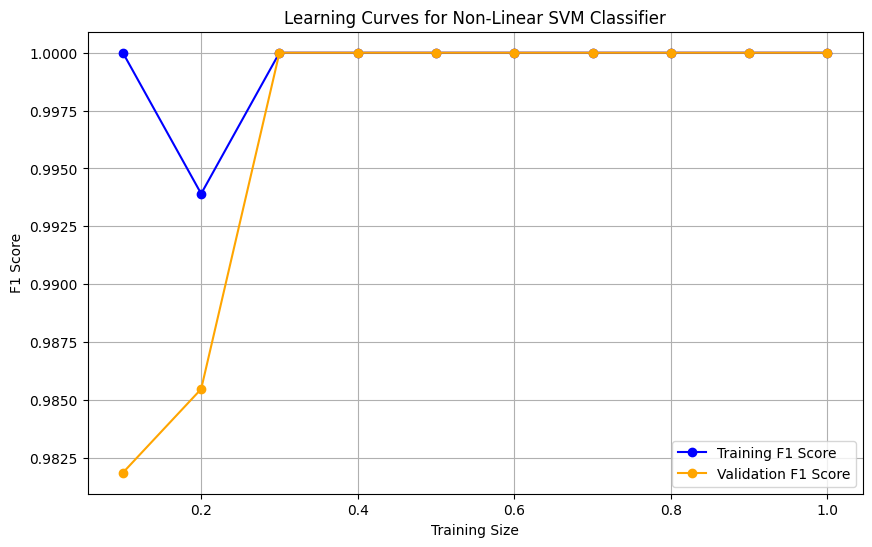

F1 Score for Non-Linear SVM: 1.0000


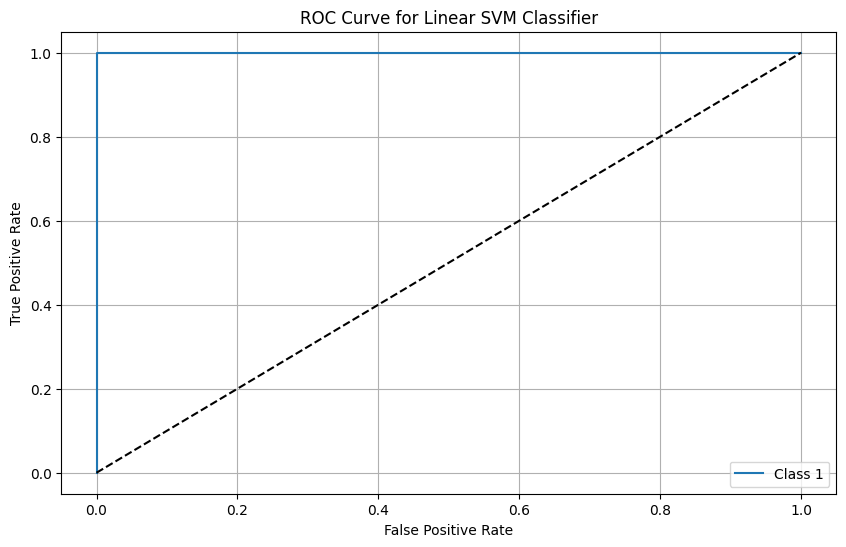

Average AUC for Linear SVM: 1.0000


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Function to generate learning curve data for Non-Linear SVM
def generate_learning_curve_svm(X_train, y_train, X_test, y_test, C=10, gamma=0.1):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
    train_f1_scores = []
    val_f1_scores = []

    # Loop over each training size
    for train_size in train_sizes:
        # Calculate the number of samples for the current train_size
        num_train_samples = int(train_size * len(X_train))

        # Subset the training data
        X_train_subset = X_train[:num_train_samples]
        y_train_subset = y_train[:num_train_samples]

        # Train the Non-Linear SVM on the current subset of training data
        svm = SVC(C=C, kernel='rbf', gamma=gamma, probability=True)
        svm.fit(X_train_subset, y_train_subset)

        # Predict on the training set
        y_train_pred = svm.predict(X_train_subset)
        train_f1 = f1_score(y_train_subset, y_train_pred, average='weighted')
        train_f1_scores.append(train_f1)

        # Predict on the test set
        y_val_pred = svm.predict(X_test)
        val_f1 = f1_score(y_test, y_val_pred, average='weighted')
        val_f1_scores.append(val_f1)

    return train_sizes, train_f1_scores, val_f1_scores

# Generate learning curves
optimal_c = 10 # Optimal c value
optimal_gamma = 0.1 # Optimal gamma value
train_sizes, train_f1_scores, val_f1_scores = generate_learning_curve_svm(X_train, y_train, X_test, y_test, C=optimal_c, gamma=optimal_gamma)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_f1_scores, marker='o', label='Training F1 Score', color='blue')
plt.plot(train_sizes, val_f1_scores, marker='o', label='Validation F1 Score', color='orange')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves for Non-Linear SVM Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Fit the Non-Linear SVM classifier on the full training data
svm = SVC(C=optimal_c, kernel='rbf', gamma=optimal_gamma, probability=True)
svm.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm.predict(X_test)

# Calculate the F1 score for the testing set
f1_svm = f1_score(y_test, y_pred, average='weighted')

# Output the F1 score for the testing set
print(f"F1 Score for Non-Linear SVM: {f1_svm:.4f}")

# ROC and AUC calculations for Non-Linear SVM
y_prob = svm.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the binary classification
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Class 1',  color='blue')

# Plotting the chance level (diagonal line)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear SVM Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the AUC score
print(f"Average AUC for Linear SVM: {roc_auc:.4f}")

**STEP 5: Display the support vectors of the Non-Linear SVM on the 2d-plane**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


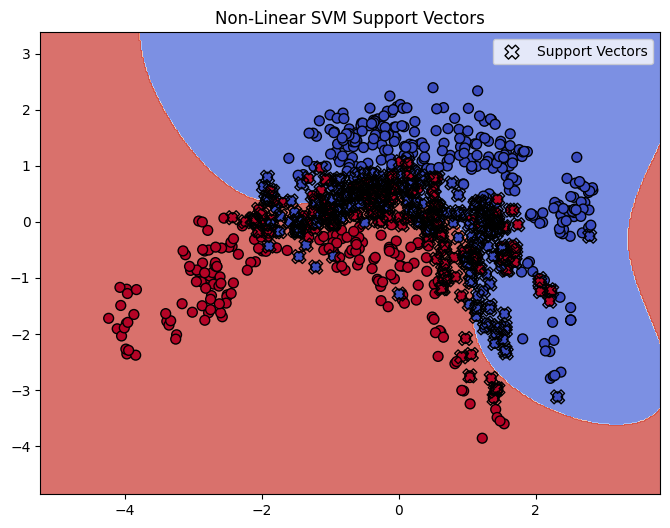

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Function to plot support vectors for Non-Linear SVM
def plot_support_vectors(X_train, y_train, svm, title='Non-Linear SVM Support Vectors'):
    plt.figure(figsize=(8, 6))

    # Plot the decision boundary
    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)

    # Plot the training points and support vectors
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', s=50, cmap=plt.cm.coolwarm)
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], facecolors='none', edgecolors='black', s=100, label='Support Vectors', marker='X')

    plt.title(title)
    plt.legend()
    plt.show()

# Fit the Non-Linear SVM classifier on the full training data
optimal_c = 10
optimal_gamma = 0.1
svm = SVC(C=optimal_c, kernel='rbf', gamma=optimal_gamma, probability=True)
svm.fit(X_train, y_train)

# Plot support vectors after training the Non-Linear SVM model
plot_support_vectors(X_train.to_numpy(), y_train, svm, title="Non-Linear SVM Support Vectors")

##**EXTRA: Gaussian Mixture**

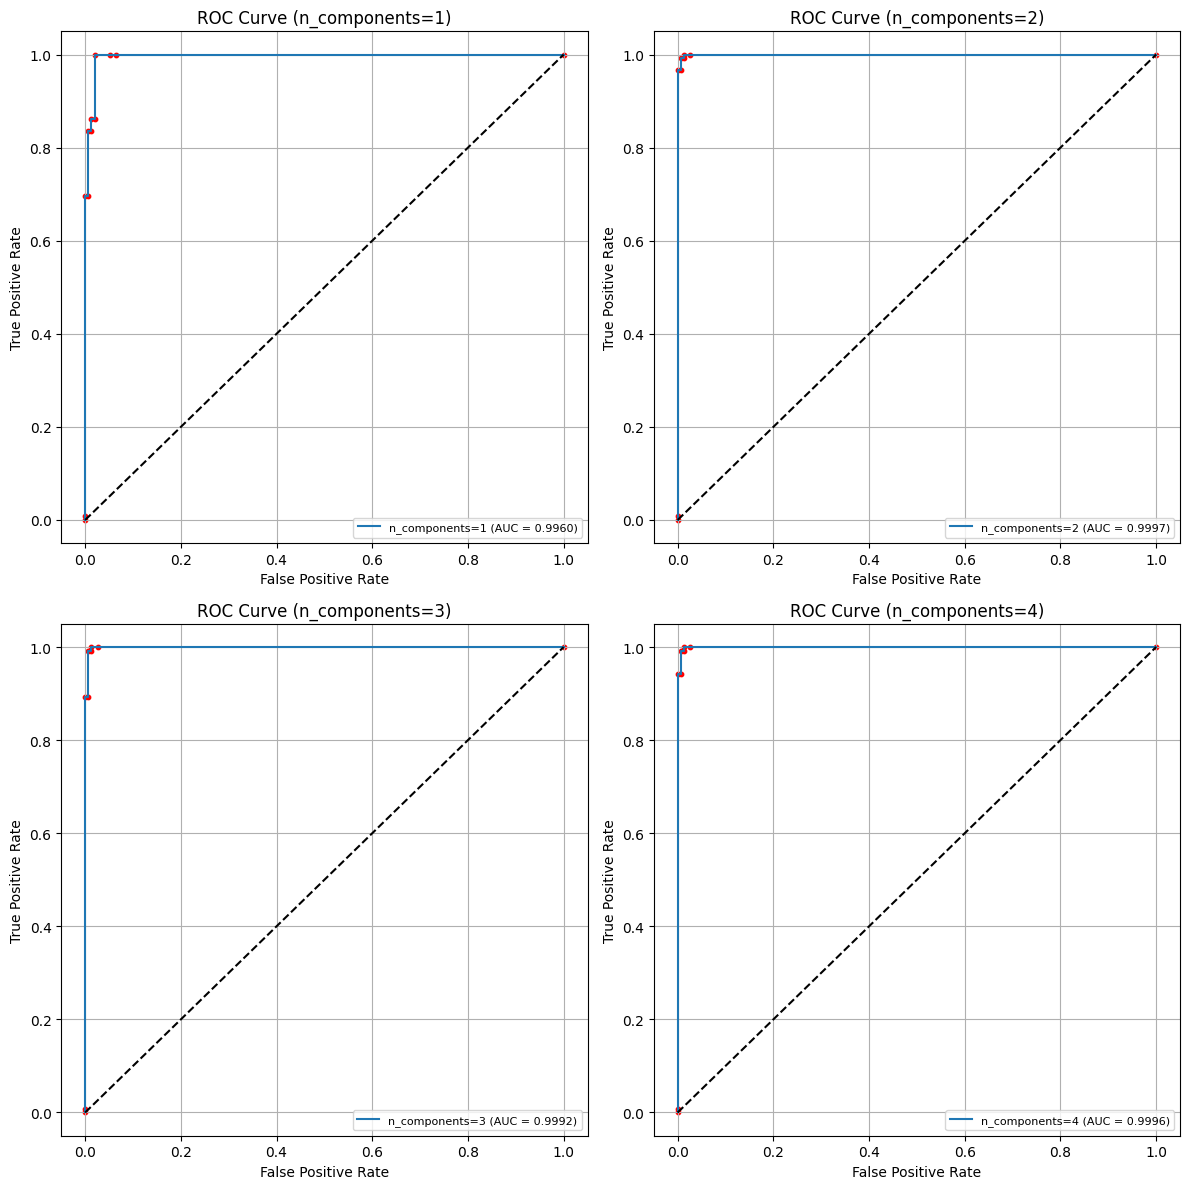

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Filter positive samples for training the GMM
X_train_positive = X_train[y_train == 1]

# Create a function to calculate and plot ROC curve for different n_components
def gm(X_train_positive, X_test, y_test, n_components_list):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    # Loop over each number of components and its corresponding subplot
    for idx, n_components in enumerate(n_components_list):
        ax = axes[idx]

        # Train the Gaussian Mixture Model with n_components
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X_train_positive)

        # Calculate probabilities for the test set
        prob = gmm.score_samples(X_test)  # score_samples returns the log likelihood
        prob = np.exp(prob)  # Convert to normal probability (log-likelihood to probability)

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, prob)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for this number of components
        ax.plot(fpr, tpr, label=f'n_components={n_components} (AUC = {roc_auc:.4f})')

        # Plot all threshold points on the current ROC curve
        for i in range(len(thresholds)):
            # Plot the threshold points as red dots
            ax.scatter(fpr[i], tpr[i], color='red', s=10)

        # Plot the random chance line
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve (n_components={n_components})')

        # Add a legend and make it readable
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Test with different numbers of components for the GMM
n_components_list = [1, 2, 3, 4]  # different values for n_components
gm(X_train_positive, X_test, y_test, n_components_list)